In [0]:
import cv2
from google.colab.patches import cv2_imshow
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from google.colab import drive
from scipy import ndimage as ndi
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Définition des paramètres du modèle

In [0]:
width = 160
height = 120

taille_batch = 50
nbr_entrainement = 100
learning_rate = 1e-3
labels = [ i for i in range(13) ]
label_count = len(labels)

# Utilisation du réseau stocké en mémoire
images_path = './drive/My Drive/images_test'
files = os.listdir(images_path)

label_names = ["Unlabeled",
               "Building",
               "Fence",
               "Other",
               "Pedestrian",
               "Pole",
               "Road line",
               "Road",
               "Sidewalk",
               "Vegetation",
               "Car",
               "Wall",
               "Traffic sign" ]

## Fonctions


In [0]:
# Fonctions utiles
def normalisation(couche_prec, training=False):
    result = tf.layers.batch_normalization(couche_prec, training=training)
    return result

def convolution(couche_prec, taille_noyau, nbr_conv,
                stride=1, training=False, normalize=True):
    w = tf.Variable(tf.random.truncated_normal(shape=(taille_noyau, taille_noyau, int(couche_prec.get_shape()[-1]), nbr_conv)))
    b = np.zeros(nbr_conv)
    result = tf.nn.conv2d(couche_prec, w, strides=[1, stride, stride, 1], padding='SAME')
    result = result + b
    if normalize:
        result = normalisation(result, training=training)
        result = tf.nn.relu(result)
    return result

def deconvolution(couche_prec, taille_noyau, nbr_conv, stride=1, training=False):
    w = tf.Variable(tf.random.truncated_normal(shape=(taille_noyau, taille_noyau, nbr_conv, int(couche_prec.get_shape()[-1]))))
    b = np.zeros(nbr_conv)
    out_h = int(couche_prec.get_shape()[1])*stride
    out_w = int(couche_prec.get_shape()[2])*stride
    b_size = tf.shape(couche_prec)[0]
    result = tf.nn.conv2d_transpose(couche_prec, w, output_shape=[b_size, out_h, out_w, nbr_conv],
                                    strides=[1, stride, stride, 1], padding='SAME')
    result = result + b
    result = normalisation(result, training=training)
    return result

def max_pool(couche_prec, stride=2):
    return tf.nn.max_pool(couche_prec, ksize = [1, stride, stride, 1],
                          strides=[1, stride, stride, 1], padding='SAME')
    
def concat(t1, t2):
    return tf.concat((t1, t2), axis=3)

# Fonctions principales
def defineNetwork():
    print("------------------------")
    print("--- Defining network ---")
    print("------------------------")

    # Les commentaires après chaque ligne indiquent les
    # dimensions du bloc dans le réseau de neurones
    # dans le cas où 2 catégories peuvent être détectées

    ph_images = tf.placeholder(shape=(None, height, width, 3), dtype=tf.float32, name='images') #(120, 160, 3)
    ph_masks = tf.placeholder(shape=(None, height, width, label_count), dtype=tf.float32)       #(120, 160, 2)
    ph_is_training = tf.placeholder_with_default(True, (), name='is_training')

    couche_d0 = convolution(ph_images, 3, 16, stride=1, training=ph_is_training) #(120, 160, 16)
    couche_d1 = convolution(couche_d0, 3, 16, stride=1, training=ph_is_training) #(120, 160, 16)
    couche_d1_mp = max_pool(couche_d1) #(60, 80, 16)

    couche_d2 = convolution(couche_d1_mp, 3, 32, stride=1, training=ph_is_training) #(60, 80, 32)
    couche_d3 = convolution(couche_d2, 3, 32, stride=1, training=ph_is_training)    #(60, 80, 32)
    couche_d3_mp = max_pool(couche_d3) #(30, 40, 32)

    couche_d4 = convolution(couche_d3_mp, 3, 64, stride=1, training=ph_is_training) #(30, 40, 64)
    couche_d5 = convolution(couche_d4, 3, 64, stride=1, training=ph_is_training)    #(30, 40, 64)
    couche_d5_mp = max_pool(couche_d5) #(15, 20, 64)

    couche_d6 = convolution(couche_d5_mp, 3, 128, stride=1, training=ph_is_training) #(15, 20, 128)
    couche_d7 = convolution(couche_d6, 3, 128, stride=1, training=ph_is_training)    #(15, 20, 128)

    couche_u7 = deconvolution(couche_d7, 3, 64, stride=2, training=ph_is_training) #(30, 40, 64)
    couche_u7 = concat(couche_d5, couche_u7) #(30, 40, 128)

    couche_u6 = convolution(couche_u7, 3, 64, stride=1, training=ph_is_training)   #(30, 40, 64)
    couche_u5 = convolution(couche_u6, 3, 64, stride=1, training=ph_is_training)   #(30, 40, 64)
    couche_u5 = deconvolution(couche_u5, 3, 64, stride=2, training=ph_is_training) #(60, 80, 64)
    couche_u5 = concat(couche_d3, couche_u5) #(60, 80, 96)

    couche_u4 = convolution(couche_u5, 3, 32, stride=1, training=ph_is_training)   #(60, 80, 32)
    couche_u3 = convolution(couche_u4, 3, 32, stride=1, training=ph_is_training)   #(60, 80, 32)
    couche_u3 = deconvolution(couche_u5, 3, 32, stride=2, training=ph_is_training) #(120, 160, 32)
    couche_u3 = concat(couche_d1, couche_u3) #(120, 160, 48)

    couche_u2 = convolution(couche_u3, 3, 16, stride=1, training=ph_is_training) #(120, 160, 16)
    couche_u1 = convolution(couche_u2, 3, 16, stride=1, training=ph_is_training) #(120, 160, 16)
    result = convolution(couche_u1, 1, label_count, stride=1, normalize=False)   #(120, 160, 2)

    mask = tf.nn.sigmoid(result, name='sortie') #(120, 160, 2)

    print("---------------------------")
    print("--- Defining network OK ---")
    print("---------------------------")

    return ph_images, ph_masks, ph_is_training, mask

def defineMetrics(ph_masks, mask):
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ph_masks, logits=mask)
    train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(mask), ph_masks), tf.float32))
    return loss, train, accuracy

def dataConditioning(dir_img="CameraRGB/", dir_mask="CameraSeg/"):
    tab_img = []
    tab_mask = []

    print("---------------------------")
    print("--- Image conditionning ---")
    print("---------------------------")

    image_count = 0
    for dir in ['/content/drive/My Drive/dataset/lyft-udacity-challenge/resized/dataA/',
                '/content/drive/My Drive/dataset/lyft-udacity-challenge/resized/dataB/']:
        for file in os.listdir(dir+dir_img):
            print(f"Conditioning image {image_count}")
            image_count += 1
            tab_img.append(cv2.imread(dir+dir_img+file)/255)
            img_mask = cv2.imread(dir+dir_mask+file)[:,:,2]
            img_mask_result = np.zeros(shape=(height, width, label_count), dtype=np.float32)

            for i, label in enumerate(labels):
                img_mask_result[:,:,i][img_mask==label]=1.
            
            tab_mask.append(img_mask_result)

    # Création des tableaux d'images et de masks
    tab_img = np.array(tab_img)
    tab_mask = np.array(tab_mask)

    # Ces tableaux sont splités en un set training et un set testing
    train_images, test_images, train_labels, test_labels = train_test_split(tab_img, tab_mask, test_size=.1)

    print("-------------------------------")
    print("--- Image conditionning  OK ---")
    print("-------------------------------")

    return train_images, test_images, train_labels, test_labels

# Entrainement du modèle
def trainOnce(s, taille_batch, train, train_images, train_labels):
    for batch in np.arange(0, len(train_images), taille_batch):
        s.run(train, feed_dict={
            ph_images: train_images[batch:batch+taille_batch],
            ph_masks: train_labels[batch:batch+taille_batch],
            ph_is_training: True
        })

def computeAccuracy(s, taille_batch, accuracy, images, labels):
    return np.mean(
            [s.run(accuracy, feed_dict={
                ph_images: images[batch:batch+taille_batch],
                ph_masks: labels[batch:batch+taille_batch],
                ph_is_training: True})
            for batch in range(0, len(images), taille_batch) ]
            )
    
def trainModel(train_images, test_images, train_labels, test_labels):
    print("-----------------------")
    print("--- Training model  ---")
    print("-----------------------")
    saver = tf.train.Saver()

    with tf.Session() as s:
        s.run(tf.global_variables_initializer())

        train_errors = []
        test_errors = []
        
        for id_entrainement in range(nbr_entrainement):
            print(f"--- Entrainement {id_entrainement} ---")
            trainOnce(s, taille_batch, train, train_images, train_labels)
            print("> entrainement OK")

            accuracy_train = computeAccuracy(s, taille_batch, accuracy,
                                             train_images, train_labels)
            accuracy_test = computeAccuracy(s, taille_batch, accuracy,
                                            test_images, test_labels)
            print(f"> train: {accuracy_train}, test: {accuracy_test}\n")

            train_errors.append(1 - accuracy_train)
            test_errors.append(1 - accuracy_test)

        saver.save(s, './mon_modele/modele')

    print("-------------------------")
    print("--- Training model OK ---")
    print("-------------------------")

    return train_errors, test_errors

def showPerformance(train_errors, test_errors, save=False, filename="performance"):
      plot.ylim(0, 1)
      plot.grid()
      plot.plot(train_errors, label="Train error")
      plot.plot(test_errors, label="Test error")
      plot.legend(loc="upper right")
      if save:
          plot.savefig(filename, dpi=300)
      plot.show()

def runNetworkOnImage(s, filename):
    image = cv2.imread(f"{images_path}/{f}")/255
    image = cv2.resize(image, (width, 120))

    img_res = s.run(sortie, feed_dict={images: [image], is_training:False})[0]

    # Affiche l'image en couleurs
    plot.imshow(image)
    plot.show()

    for i, label in enumerate(labels):
        # Affiche l'image pour le label i
        # seulement les pixels avec probabilité > 0.6 sont colorés

        print(f"--- Label : {label_names[i]} ---")
        
        # img_label = ndi.binary_dilation(ndi.binary_erosion(img_res[:, :, label] > 0.6))*255
        # Une erosion puis une dilation (pour eliminer les pixels isolés)
        # ne donnent pas un rendu plus convainquant 

        img_label = (img_res[:, :, label] > 0.6)*255
        cv2_imshow(img_label)

## Code principal

In [0]:
train_images, test_images, train_labels, test_labels = dataConditioning()
ph_images, ph_masks, ph_is_training, mask = defineNetwork()
loss, train, accuracy = defineMetrics(ph_masks, mask)

---------------------------
--- Image conditionning ---
---------------------------
Conditioning image 0
Conditioning image 1
Conditioning image 2
Conditioning image 3
Conditioning image 4
Conditioning image 5
Conditioning image 6
Conditioning image 7
Conditioning image 8
Conditioning image 9
Conditioning image 10
Conditioning image 11
Conditioning image 12
Conditioning image 13
Conditioning image 14
Conditioning image 15
Conditioning image 16
Conditioning image 17
Conditioning image 18
Conditioning image 19
Conditioning image 20
Conditioning image 21
Conditioning image 22
Conditioning image 23
Conditioning image 24
Conditioning image 25
Conditioning image 26
Conditioning image 27
Conditioning image 28
Conditioning image 29
Conditioning image 30
Conditioning image 31
Conditioning image 32
Conditioning image 33
Conditioning image 34
Conditioning image 35
Conditioning image 36
Conditioning image 37
Conditioning image 38
Conditioning image 39
Conditioning image 40
Conditioning image 41
Co

-----------------------
--- Training model  ---
-----------------------
--- Entrainement 0 ---
> entrainement OK
> train: 0.49803146719932556, test: 0.49841997027397156

--- Entrainement 1 ---
> entrainement OK
> train: 0.5506283044815063, test: 0.5519727468490601

--- Entrainement 2 ---
> entrainement OK
> train: 0.598122239112854, test: 0.5997267365455627

--- Entrainement 3 ---
> entrainement OK
> train: 0.6506404280662537, test: 0.6528621912002563

--- Entrainement 4 ---
> entrainement OK
> train: 0.7097694873809814, test: 0.7121931910514832

--- Entrainement 5 ---
> entrainement OK
> train: 0.7502943277359009, test: 0.7522081136703491

--- Entrainement 6 ---
> entrainement OK
> train: 0.7779119610786438, test: 0.7795661687850952

--- Entrainement 7 ---
> entrainement OK
> train: 0.8016729950904846, test: 0.8029888868331909

--- Entrainement 8 ---
> entrainement OK
> train: 0.8250812888145447, test: 0.8261188268661499

--- Entrainement 9 ---
> entrainement OK
> train: 0.86411416530

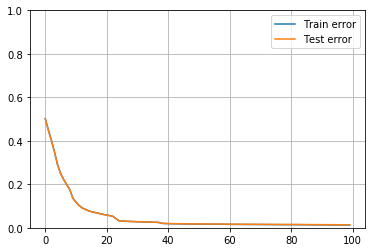

In [0]:
train_errors, test_errors = trainModel(train_images, test_images, train_labels, test_labels)
showPerformance(train_errors, test_errors, save=True)

INFO:tensorflow:Restoring parameters from ./drive/My Drive/modele_2000_images_13_labels/modele

--- Image 0 ---


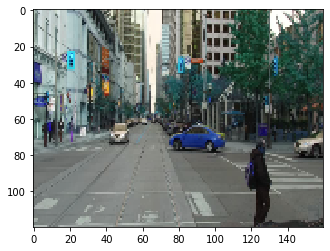

--- Label : Unlabeled ---


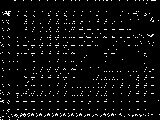

--- Label : Building ---


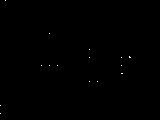

--- Label : Fence ---


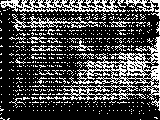

--- Label : Other ---


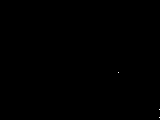

--- Label : Pedestrian ---


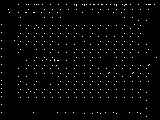

--- Label : Pole ---


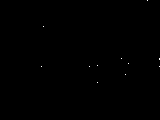

--- Label : Road line ---


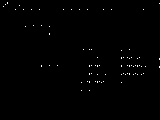

--- Label : Road ---


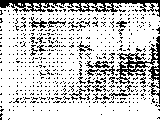

--- Label : Sidewalk ---


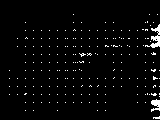

--- Label : Vegetation ---


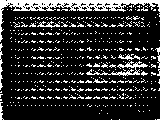

--- Label : Car ---


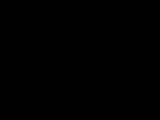

--- Label : Wall ---


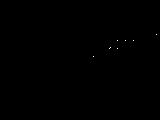

--- Label : Traffic sign ---


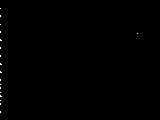


--- Image 1 ---


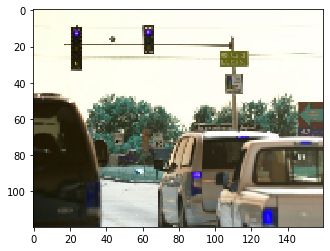

--- Label : Unlabeled ---


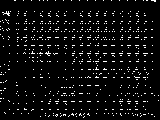

--- Label : Building ---


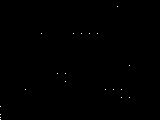

--- Label : Fence ---


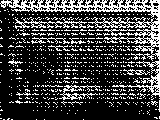

--- Label : Other ---


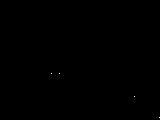

--- Label : Pedestrian ---


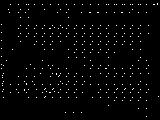

--- Label : Pole ---


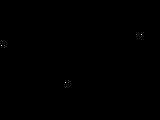

--- Label : Road line ---


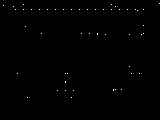

--- Label : Road ---


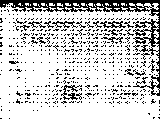

--- Label : Sidewalk ---


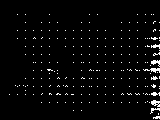

--- Label : Vegetation ---


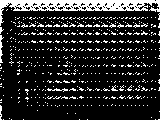

--- Label : Car ---


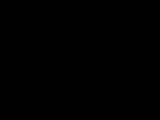

--- Label : Wall ---


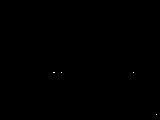

--- Label : Traffic sign ---


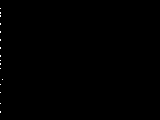


--- Image 2 ---


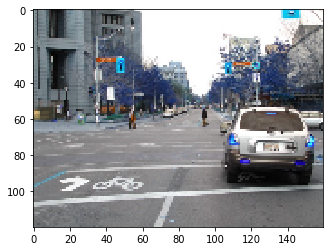

--- Label : Unlabeled ---


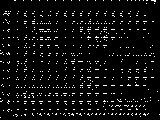

--- Label : Building ---


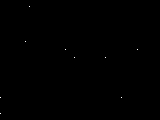

--- Label : Fence ---


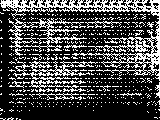

--- Label : Other ---


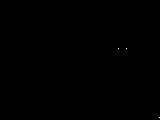

--- Label : Pedestrian ---


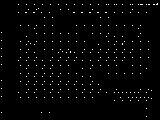

--- Label : Pole ---


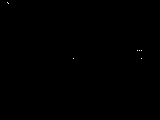

--- Label : Road line ---


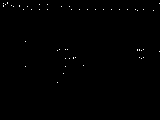

--- Label : Road ---


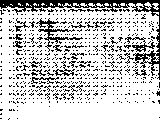

--- Label : Sidewalk ---


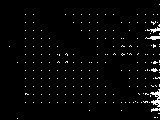

--- Label : Vegetation ---


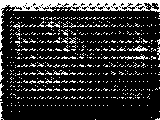

--- Label : Car ---


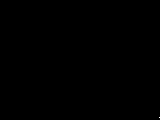

--- Label : Wall ---


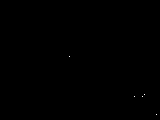

--- Label : Traffic sign ---


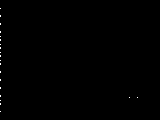


--- Image 3 ---


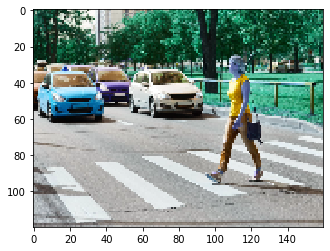

--- Label : Unlabeled ---


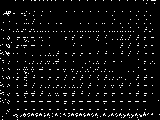

--- Label : Building ---


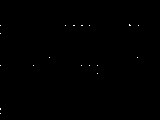

--- Label : Fence ---


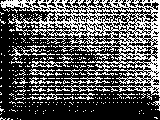

--- Label : Other ---


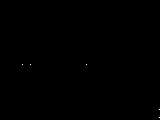

--- Label : Pedestrian ---


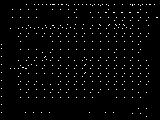

--- Label : Pole ---


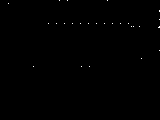

--- Label : Road line ---


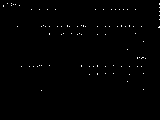

--- Label : Road ---


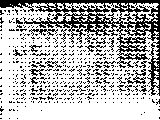

--- Label : Sidewalk ---


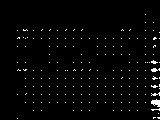

--- Label : Vegetation ---


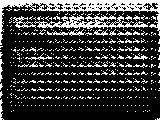

--- Label : Car ---


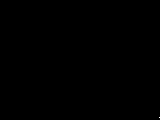

--- Label : Wall ---


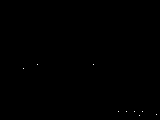

--- Label : Traffic sign ---


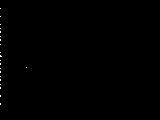


--- Image 4 ---


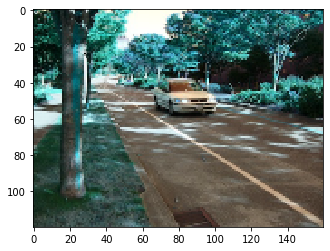

--- Label : Unlabeled ---


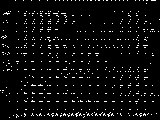

--- Label : Building ---


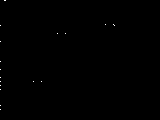

--- Label : Fence ---


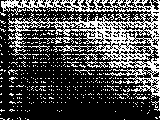

--- Label : Other ---


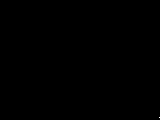

--- Label : Pedestrian ---


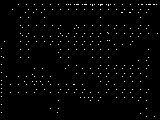

--- Label : Pole ---


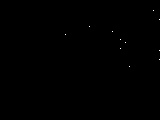

--- Label : Road line ---


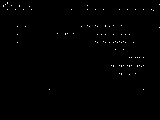

--- Label : Road ---


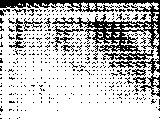

--- Label : Sidewalk ---


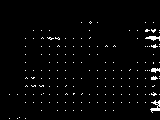

--- Label : Vegetation ---


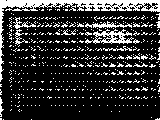

--- Label : Car ---


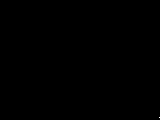

--- Label : Wall ---


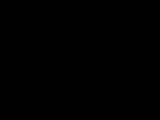

--- Label : Traffic sign ---


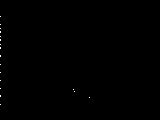

In [0]:
with tf.Session() as s:
    saver=tf.train.import_meta_graph('./drive/My Drive/modele_2000_images_13_labels/modele.meta')
    saver.restore(s, tf.train.latest_checkpoint('./drive/My Drive/modele_2000_images_13_labels'))
    graph=tf.get_default_graph()
    images=graph.get_tensor_by_name("images:0")
    sortie=graph.get_tensor_by_name("sortie:0")
    is_training=graph.get_tensor_by_name("is_training:0")

    for i, f in enumerate(os.listdir(images_path)):
        print(f"\n--- Image {i} ---")
        runNetworkOnImage(s, f)